## Telco Customer Churn - StatsModel Log Regression with Variance Inflation Factor (VIF) 

In [30]:
%matplotlib inline

import os
import sys
import json
import keras

from pathlib import Path
from pathlib import PureWindowsPath

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics

import lime

import lime.explanation 

import lime.lime_tabular

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation

# Constants for Functions (Temporary)
ALGORITHM_NAME = 'lr'
COUNTRY = 'mwi'

In [31]:
# Change the default directory
os.chdir('/home/mike/Documents/mkp_code/Institute of Data Course/telco-customer-churn-project/data/processed')

In [32]:
# Upload Customer Churn data to dataframe
customer_data = pd.read_csv('Telco-Customer-Churn-Processed.csv')

In [33]:
# Drop Unnamed: 0 - This column is not needed
customer_data.drop('Unnamed: 0',axis=1,inplace=True)

In [34]:
# Divide the variables from the target column
target_col = ['Churn']

# Remove the target column
categorical_cols = customer_data.columns
categorical_cols = [col for col in categorical_cols if col not in target_col]

In [35]:
# Variables to a dataframe for processing
X= customer_data[categorical_cols]

In [36]:
# select y = Target Column - Churn
y = customer_data.Churn

In [37]:
def get_vif(X, intercept_col='intercept'):
    if intercept_col is not None and intercept_col in X.columns:
        X = X.copy().drop(intercept_col, axis=1)
    
    vi_factors = [variance_inflation_factor(X.values, i)
                             for i in range(X.shape[1])]
    
    return pd.Series(vi_factors,
                     index=X.columns,
                     name='variance_inflaction_factor')

In [38]:
# Store coefs for graphs
def get_coefs_df(X, coefs, index=None):
    coefs_df = pd.DataFrame(np.std(X, 0)*coefs)
    coefs_df.columns = ["coef_std"]
    coefs_df['coef'] = coefs
    coefs_df['abs'] = coefs_df.coef_std.apply(abs)
    if index is not None:
        coefs_df.index = index
    return coefs_df

In [39]:
# Partition the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [40]:
get_vif(x_train)

gender               1.991691
SeniorCitizen        1.352970
Partner              2.757556
Dependents           1.947745
tenure              18.385922
PhoneService        13.762613
MultipleLines        2.636832
InternetService      4.273488
OnlineSecurity       2.287856
OnlineBackup         2.463190
DeviceProtection     2.612800
TechSupport          2.391574
StreamingTV          3.198396
StreamingMovies      3.266762
Contract             4.160630
PaperlessBilling     2.809816
PaymentMethod        3.692459
MonthlyCharges       4.785527
TotalCharges        10.328571
tenure_group        28.188603
Name: variance_inflaction_factor, dtype: float64

In [41]:
categorical_cols = [(get_vif(x_train)<4)]

In [42]:
print(categorical_cols)

[gender               True
SeniorCitizen        True
Partner              True
Dependents           True
tenure              False
PhoneService        False
MultipleLines        True
InternetService     False
OnlineSecurity       True
OnlineBackup         True
DeviceProtection     True
TechSupport          True
StreamingTV          True
StreamingMovies      True
Contract            False
PaperlessBilling     True
PaymentMethod        True
MonthlyCharges      False
TotalCharges        False
tenure_group        False
Name: variance_inflaction_factor, dtype: bool]


In [43]:
# Remove variables with a high VIF
x_train.drop(['tenure','PhoneService', 'InternetService','Contract','MonthlyCharges','TotalCharges','tenure_group'],axis=1,inplace=True)

In [44]:
# Set the Logistic Regression with reduced number of variables
model = sm.Logit(y_train, x_train)
model = model.fit()

Optimization terminated successfully.
         Current function value: 0.490738
         Iterations 6


In [45]:
# Save coefs 
coefs = get_coefs_df(x_train, model.params)
coefs

,coef_std,coef,abs
gender,-0.073945,-0.147892,0.073945
SeniorCitizen,0.136610,0.370706,0.136610
Partner,-0.167968,-0.336329,0.167968
Dependents,-0.139155,-0.305586,0.139155
MultipleLines,0.057071,0.060138,0.057071
OnlineSecurity,-0.496504,-0.578589,0.496504
OnlineBackup,-0.302246,-0.343935,0.302246
DeviceProtection,-0.249828,-0.284140,0.249828
TechSupport,-0.473261,-0.550733,0.473261
StreamingTV,0.026161,0.029581,0.026161


In [46]:
# Run the model
y_prob = model.predict(x_train)
y_prob.head()

5925    0.233283
4395    0.264846
1579    0.642028
1040    0.615755
1074    0.163644
dtype: float64

In [47]:
# Define the y_pred
y_pred = (y_prob > 0.5)

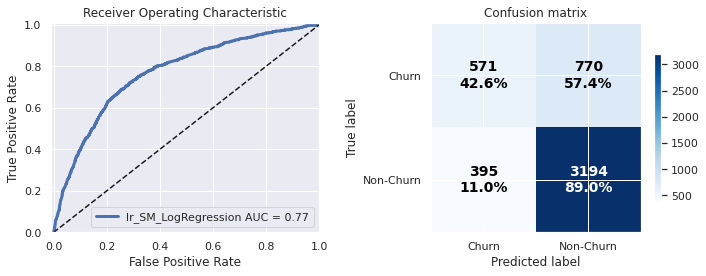

,lr_SM_LogRegression
accuracy,0.763692
recall,0.425802
precision,0.591097
f1,0.495015
cross_entropy,0.490738
roc_auc,0.770640
cohen_kappa,0.346049


In [48]:
# Evaluate performance
metrics = evaluation.evaluate_model(y_train, y_pred, y_prob, 
                                    store_model=True, 
                                    model_name='SM_LogRegression', 
                                    prefix=ALGORITHM_NAME, 
                                    country=COUNTRY, 
                                    model=model, 
                                    features=coefs)

In [49]:
# Set the Logistic Regression with reduced number of variables
model = sm.Logit(y_test, x_test)
model = model.fit()

Optimization terminated successfully.
         Current function value: 0.388826
         Iterations 8


In [50]:
# Save coefs 
coefs = get_coefs_df(x_test, model.params)
coefs

,coef_std,coef,abs
gender,-0.063459,-0.126939,0.063459
SeniorCitizen,0.032117,0.087098,0.032117
Partner,-0.018777,-0.037553,0.018777
Dependents,-0.215453,-0.464313,0.215453
tenure,-1.224028,-1.223699,1.224028
PhoneService,-0.414196,-1.390355,0.414196
MultipleLines,0.015685,0.016558,0.015685
InternetService,0.234932,0.317796,0.234932
OnlineSecurity,-0.261299,-0.302585,0.261299
OnlineBackup,-0.146145,-0.165520,0.146145


In [51]:
# Run the model
y_prob = model.predict(x_test)
y_prob.head()

3381    0.063651
6180    0.072910
4829    0.323553
3737    0.494716
4249    0.169562
dtype: float64

In [52]:
# Define the y_pred
y_pred = (y_prob > 0.5)

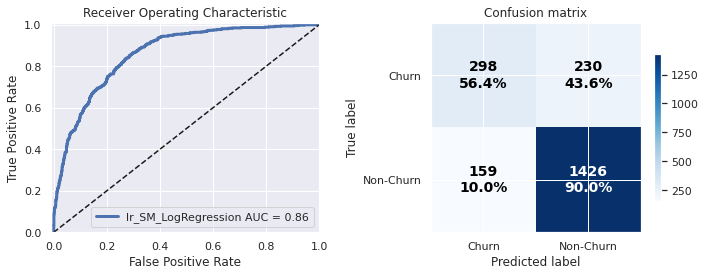

,lr_SM_LogRegression
accuracy,0.815902
recall,0.564394
precision,0.652079
f1,0.605076
cross_entropy,0.388826
roc_auc,0.861818
cohen_kappa,0.485863


In [53]:
# Evaluate performance
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    store_model=True, 
                                    model_name='SM_LogRegression', 
                                    prefix=ALGORITHM_NAME, 
                                    country=COUNTRY, 
                                    model=model, 
                                    features=coefs)

In [54]:
categorical_cols =x_test.columns.values 

In [55]:
# LIME has one explainer for all models 
explainer = lime.lime_tabular.LimeTabularExplainer(x_test.values,          feature_names=x_test.columns.values.tolist(),                          class_names=['Churn'],                             categorical_features=categorical_cols,verbose=True, mode='regression')

Intercept 0.3263944479853901
Prediction_local [0.05564724]
Right: 0.06365121313009411


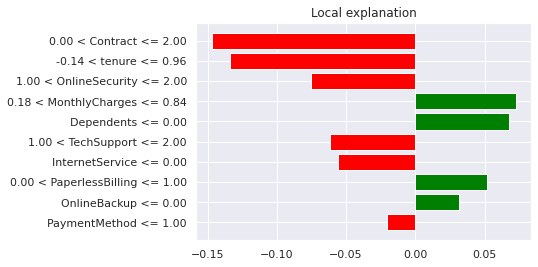

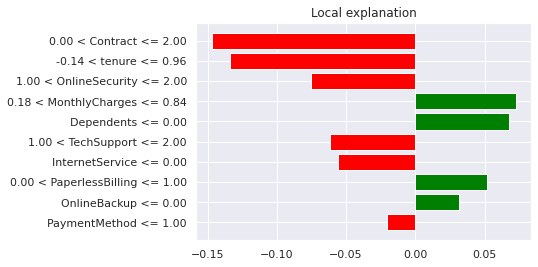

In [56]:
# Plot the explainer
exp = explainer.explain_instance(x_test.iloc[0], model.predict)
exp.as_pyplot_figure()